In [1]:
%load_ext autoreload
%autoreload 2


import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from model import LSTM_fixed_len
from train import *
from utils import ReviewsDataset
from sklearn.utils import class_weight
from pyvi import ViTokenizer
from collections import Counter

# Load data

In [2]:
data_path = '/home/taindp/Jupyter/intent_bert/data'
model_path = '/home/taindp/Jupyter/intent_bert/model'

In [3]:
question = pd.read_csv(os.path.join(data_path,'question_livestream_label.csv'))

In [4]:
question

,label,content
0,1,thầy cho em hỏi nếu mình đã trúng tuyển chương...
1,0,cho em hỏi em có thể đăng kí 2 ngành được khôn...
2,1,cho em hỏi chương trình chất lượng cao ở bách ...
3,1,cho em hỏi nếu em đã trúng tuyển chương trình ...
4,0,thầy ơi cho em hỏi ví dụ nếu mình chọn nguyện ...
...,...,...
428,3,cho em hỏi về ngành kỹ thuật hoá học và cơ hội...
429,3,cho em xin giới thiệu về ngành kỹ thuật robot ạ
430,3,ngành khoa học máy tính sau này ra làm công vi...
431,3,em muốn học tự động hoá thì tương lai sẽ có ng...


In [5]:
question['length'] = [len(item) for item in list(question['content'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['content'])]

In [6]:
np.mean(question['length'])

71.89838337182448

(array([ 96., 169.,  86.,  49.,  25.,   4.,   3.,   0.,   0.,   1.]),
 array([ 6. , 11.6, 17.2, 22.8, 28.4, 34. , 39.6, 45.2, 50.8, 56.4, 62. ]),
 <BarContainer object of 10 artists>)

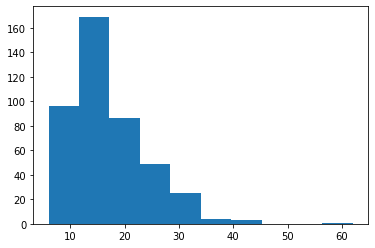

In [7]:
plt.hist(list(question['num_word']), bins = 10)

In [8]:
def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

In [9]:
counts = Counter()
for index, row in question.iterrows():
    counts.update(tokenize(row['content']))

In [10]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 616
num_words after: 365


In [11]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [12]:
def encode_sentence(text, vocab2index, N=75):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    return [encoded]
#     return encoded, length

In [13]:
question['encoded'] = question['content'].apply(lambda x: np.array(encode_sentence(x,vocab2index)))
question.head()

,label,content,length,num_word,encoded
0,1,thầy cho em hỏi nếu mình đã trúng tuyển chương...,159,33,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,0,cho em hỏi em có thể đăng kí 2 ngành được khôn...,137,33,"[[3, 4, 5, 4, 13, 25, 26, 27, 22, 23, 4, 25, 2..."
2,1,cho em hỏi chương trình chất lượng cao ở bách ...,106,24,"[[3, 4, 5, 10, 16, 17, 32, 33, 34, 22, 35, 36,..."
3,1,cho em hỏi nếu em đã trúng tuyển chương trình ...,148,31,"[[3, 4, 5, 6, 4, 8, 9, 10, 11, 12, 4, 13, 40, ..."
4,0,thầy ơi cho em hỏi ví dụ nếu mình chọn nguyện ...,273,62,"[[2, 41, 3, 4, 5, 42, 6, 7, 43, 44, 45, 46, 47..."


In [14]:
X = list(question['encoded'])
y = list(question['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=(1-0.693))

In [15]:
len(X_train)

300

In [16]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y).tolist(),y)
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights

/home/taindp/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1, 2, 3], y=[1, 0, 1, 1, 0, 2, 0, 3, 2, 1, 1, 3, 0, 1, 3, 1, 3, 3, 0, 3, 0, 2, 3, 0, 3, 0, 2, 0, 3, 1, 3, 3, 3, 1, 0, 2, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 0, 3, 3, 2, 2, 0, 1, 1, 3, 1, 2, 0, 3, 0, 0, 0, 2, 2, 1, 0, 3, 1, 0, 3, 1, 1, 0, 3, 3, 2, 1, 3, 3, 3, 1, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 1, 1, 0, 0, 1, 3, 0, 0, 3, 3, 3, 2, 3, 2, 3, 0, 3, 3, 2, 3, 1, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 3, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 3, 1, 0, 2, 0, 0, 1, 2, 2, 3, 2, 3, 2, 3, 1, 3, 2, 0, 3, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 3,

tensor([1.4829, 1.4829, 0.8457, 0.6808])

In [17]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [18]:
batch_size = 128
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [19]:
model_fixed =  LSTM_fixed_len(
                           vocab_size = vocab_size,\
                           embedding_dim = 400,\
                           hidden_dim = 100,\
                           num_layers = 2, \
                           bidirectional=True,\
                           dropout=0.44,\
                           n_class = class_weights.shape[0])
model_fixed.cpu()

LSTM_fixed_len(
  (embeddings): Embedding(367, 400, padding_idx=0)
  (lstm): LSTM(400, 100, num_layers=2, batch_first=True, dropout=0.44, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.44, inplace=False)
)

In [20]:
optimizer = torch.optim.Adam(model_fixed.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight = class_weights)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [21]:

loss=[]
acc=[]
val_loss=[]
acc_max = 0
for epoch in range(20):
    train_loss = train_model(model_fixed,train_dl,optimizer,criterion)
    valid_loss = evaluate (model_fixed, val_dl,criterion)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
#     print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    print('='*50)
#     print('pred',pred)
    loss.append(train_loss)
#     acc.append(train_acc)
    val_loss.append(valid_loss)
    exp_lr_scheduler.step()
    list_true = []
    for x,y in train_dl:
        list_true.append(y)
#     print(confusion_matrix(pred,list_true))

Epoch-0 lr: 0.01
	Train Loss: 1.406 | Valid Loss: 1.141
Epoch-1 lr: 0.01
	Train Loss: 1.335 | Valid Loss: 1.085
Epoch-2 lr: 0.01
	Train Loss: 1.114 | Valid Loss: 0.554
Epoch-3 lr: 0.01
	Train Loss: 0.864 | Valid Loss: 0.401
Epoch-4 lr: 0.01
	Train Loss: 0.668 | Valid Loss: 0.657
Epoch-5 lr: 0.002
	Train Loss: 0.590 | Valid Loss: 0.516
Epoch-6 lr: 0.002
	Train Loss: 0.524 | Valid Loss: 0.323
Epoch-7 lr: 0.002
	Train Loss: 0.455 | Valid Loss: 0.443
Epoch-8 lr: 0.002
	Train Loss: 0.403 | Valid Loss: 0.565
Epoch-9 lr: 0.002
	Train Loss: 0.445 | Valid Loss: 0.472
Epoch-10 lr: 0.0004
	Train Loss: 0.424 | Valid Loss: 0.444
Epoch-11 lr: 0.0004
	Train Loss: 0.382 | Valid Loss: 0.410
Epoch-12 lr: 0.0004
	Train Loss: 0.376 | Valid Loss: 0.367
Epoch-13 lr: 0.0004
	Train Loss: 0.475 | Valid Loss: 0.331
Epoch-14 lr: 0.0004
	Train Loss: 0.404 | Valid Loss: 0.306
Epoch-15 lr: 8e-05
	Train Loss: 0.346 | Valid Loss: 0.303
Epoch-16 lr: 8e-05
	Train Loss: 0.383 | Valid Loss: 0.300
Epoch-17 lr: 8e-05
	Trai

In [22]:
checkpoint = {'model': model_fixed,
      'state_dict': model_fixed.state_dict(),
      'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, os.path.join(model_path,'checkpoint.pth'))

In [23]:
list_pred = []
list_true = []
for x,y in val_dl:
    x = x.long()
    pred = model_fixed(x)
    for item in pred:
#         print(item.argmax())
        list_pred.append(item.argmax().item())
    for true in y:
        list_true.append(true.item())
#         print(true.item())

In [24]:
confusion_matrix(list_pred,list_true)

array([[17,  1,  3,  0],
       [ 2, 17,  0,  1],
       [ 3,  1, 39,  0],
       [ 2,  1,  2, 44]])

In [39]:
np.average(f1_score(list_true, list_pred, average=None))

0.859569373114861

# Test

In [26]:
load_model = load_checkpoint(os.path.join(model_path,'checkpoint.pth'))

In [27]:
load_model

LSTM_fixed_len(
  (embeddings): Embedding(367, 400, padding_idx=0)
  (lstm): LSTM(400, 100, num_layers=2, batch_first=True, dropout=0.44, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.44, inplace=False)
)

In [28]:
# filename = os.path.join(model_path,'model_intent.pth')
# joblib.dump(load_model, filename)
# # with open('vectorizer.pickle', 'wb') as handle:
# #     pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
import requests
url = 'https://api-intent.herokuapp.com/predict'
pred = requests.post(url,json={'message':'ad cho em hỏi chương trình tiên tiến với chất lượng cao khác nhau thế nào ạ'})
print(pred.json())


{'intent': 'type_edu', 'message': 'ad cho em hỏi chương trình tiên tiến với chất lượng cao khác nhau thế nào ạ', 'probability': 0.9988272786140442}


In [30]:
# for x,y in val_dl:
#     print(x.shape)

In [31]:
# torch.save(vocab2index,os.path.join(model_path,'vocab.pth'))

In [32]:
vocab2index = torch.load(os.path.join(model_path,'vocab.pth'))

In [33]:
test_sent = 'ad cho em hỏi ngành điện tử viễn thông có ổn không ạ'
test_enc =  torch.from_numpy(encode_sentence(test_sent, vocab2index, N=75)[0].astype(np.float32))
test_enc = torch.reshape(test_enc,(1,75))
test_enc

tensor([[316.,   3.,   4.,   5.,  27.,  97., 184.,  34.,   1.,  23.,  24.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.]])

In [34]:

preds = load_model(test_enc.long())
prop_preds = nn.functional.softmax(preds,dim=1)
print(prop_preds)
pred_label = prop_preds.argmax().item()
pred_label

tensor([[0.3341, 0.0905, 0.2159, 0.3595]])


3